# Implementation of DLRM (Full/Faktor 2/Central) 

## Imports

In [2]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


✅ The installed version of syft==0.8.4 matches the requirement >=0.8.2b0 and the requirement <0.9


## Load and preprocess the data

In [3]:
# Load the dataset and fill the nan with 0
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]
df = pd.read_csv('/Users/alex/Thesis/New Dataset/train.txt', sep='\t', names=columns).fillna(0)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,0.0,2,0.0,2.0,41171.0,90.0,0.0,2.0,47.0,...,07c540c4,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
1364725,0,0.0,3,7.0,10.0,3912.0,400.0,2.0,17.0,104.0,...,e5ba7672,698d1c68,0,0,08119c8b,0,32c7478e,f96a556f,0,0
1364726,0,0.0,1,48.0,0.0,17375.0,0.0,0.0,0.0,0.0,...,e5ba7672,7b06fafe,2f4b9dd2,a458ea53,033d948f,0,32c7478e,226b0ab6,2bf691b1,9aed84e6
1364727,0,0.0,0,49.0,2.0,16610.0,0.0,0.0,6.0,0.0,...,1e88c74f,c21c3e4c,efa3470f,a458ea53,d3563291,0,bcdee96c,f88869fd,9b3e8820,86fe1bbe


In [4]:
# Preprocess Dense Features
dense_cols = [c for c in columns if 'I' in c]
df[dense_cols] = preprocessing.StandardScaler().fit_transform(df[dense_cols])
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.126764,-0.267956,-0.039644,-0.661748,-0.250526,-0.228230,0.020912,-0.391033,0.389777,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,0.018618,-0.270689,0.104480,-0.536490,-0.269520,-0.217521,-0.208636,-0.391033,-0.454746,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,0.018618,-0.270689,-0.054426,1.091864,-0.259652,-0.000653,-0.173320,-0.391033,0.695141,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,-0.272146,2.170260,-0.058121,-0.661748,-0.205861,-0.238940,-0.243951,-0.460362,-0.473831,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,0.164000,-0.273423,-0.058121,-0.661748,-0.271004,-0.238940,-0.190978,-0.460362,-0.473831,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,-0.272146,-0.265222,-0.058121,-0.411232,0.339901,0.002024,-0.243951,-0.391033,-0.249579,...,07c540c4,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
1364725,0,-0.272146,-0.262489,-0.032253,0.590832,-0.212983,0.832010,-0.208636,0.128934,0.022386,...,e5ba7672,698d1c68,0,0,08119c8b,0,32c7478e,f96a556f,0,0
1364726,0,-0.272146,-0.267956,0.119262,-0.661748,-0.013207,-0.238940,-0.243951,-0.460362,-0.473831,...,e5ba7672,7b06fafe,2f4b9dd2,a458ea53,033d948f,0,32c7478e,226b0ab6,2bf691b1,9aed84e6
1364727,0,-0.272146,-0.270689,0.122957,-0.411232,-0.024558,-0.238940,-0.243951,-0.252375,-0.473831,...,1e88c74f,c21c3e4c,efa3470f,a458ea53,d3563291,0,bcdee96c,f88869fd,9b3e8820,86fe1bbe


In [5]:
# Preprocess Categorical Features
cat_cols = [c for c in columns if 'C' in c]
mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, df[col].unique()), cat_cols)
}
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping.get)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.126764,-0.267956,-0.039644,-0.661748,-0.250526,-0.228230,0.020912,-0.391033,0.389777,...,0,0,0,0,0,0,0,0,0,0
1,0,0.018618,-0.270689,0.104480,-0.536490,-0.269520,-0.217521,-0.208636,-0.391033,-0.454746,...,1,1,0,1,1,0,0,1,0,1
2,0,0.018618,-0.270689,-0.054426,1.091864,-0.259652,-0.000653,-0.173320,-0.391033,0.695141,...,2,2,1,2,2,1,0,2,1,2
3,0,-0.272146,2.170260,-0.058121,-0.661748,-0.205861,-0.238940,-0.243951,-0.460362,-0.473831,...,3,3,1,2,3,0,0,3,1,2
4,0,0.164000,-0.273423,-0.058121,-0.661748,-0.271004,-0.238940,-0.190978,-0.460362,-0.473831,...,3,4,1,2,4,0,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,-0.272146,-0.265222,-0.058121,-0.411232,0.339901,0.002024,-0.243951,-0.391033,-0.249579,...,1,246,1,2,4,0,1,4,1,2
1364725,0,-0.272146,-0.262489,-0.032253,0.590832,-0.212983,0.832010,-0.208636,0.128934,0.022386,...,0,21,1,2,144,0,1,20,1,2
1364726,0,-0.272146,-0.267956,0.119262,-0.661748,-0.013207,-0.238940,-0.243951,-0.460362,-0.473831,...,0,88,96,3,315255,0,1,2096,11,5419
1364727,0,-0.272146,-0.270689,0.122957,-0.411232,-0.024558,-0.238940,-0.243951,-0.252375,-0.473831,...,3,49,73,3,315256,0,8,29121,3,22213


In [6]:
label_counts = df.groupby('label')['I1'].count()
print(f'Baseline: {max(label_counts.values) / sum(label_counts.values) * 100}%')

Baseline: 74.63203317288634%


In [7]:
# Select halfway point for the split
split_point = len(df) // 2

# Amplify integer features in the first half by multiplying by 2
df.loc[:split_point, 'I1':'I13'] *= 2

# Dampen those integer features in the second half by dividing by 2
df.loc[split_point:, 'I1':'I13'] /= 2

# Now split the DataFrame into two parts: one with amplified features and one with dampened features
df1 = df.iloc[:split_point].reset_index(drop=True)
df2 = df.iloc[split_point:].reset_index(drop=True)

# Verifying the manipulation
print(f"Total records: {len(df)}")
print(f"df1 records: {len(df1)} - with amplified features")
print(f"df2 records: {len(df2)} - with dampened features")

# Combine df1 and df2 back into one DataFrame df
df_combined = pd.concat([df1, df2], ignore_index=True)

# Verifying the recombination
print(f"Combined DataFrame records: {len(df_combined)}")

df = df_combined

# Verify the DataFrame has been updated
print(f"Total records in updated df: {len(df)}")

Total records: 1364729
df1 records: 682364 - with amplified features
df2 records: 682365 - with dampened features
Combined DataFrame records: 1364729
Total records in updated df: 1364729


In [8]:
dense_cols = [c for c in df.columns if 'I' in c]
cat_cols = [c for c in df.columns if 'C' in c]
fixed_embedding_size = 455000
emb_counts = [len(df[c].unique()) for c in cat_cols]

## Data Owner 

In [9]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df[dense_cols].values, tf.float32),
        tf.cast(df[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [10]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [11]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [12]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
8530/8530 [==============================] - 100s 12ms/step - loss: 0.5001 - accuracy: 0.7656 - auc: 0.8366 - val_loss: 0.4736 - val_accuracy: 0.7766 - val_auc: 0.8555
Epoch 2/5
8530/8530 [==============================] - 101s 12ms/step - loss: 0.4580 - accuracy: 0.7859 - auc: 0.8658 - val_loss: 0.4699 - val_accuracy: 0.7799 - val_auc: 0.8582
Epoch 3/5
8530/8530 [==============================] - 97s 11ms/step - loss: 0.4349 - accuracy: 0.8000 - auc: 0.8802 - val_loss: 0.4799 - val_accuracy: 0.7764 - val_auc: 0.8539
Epoch 4/5
8530/8530 [==============================] - 101s 12ms/step - loss: 0.4114 - accuracy: 0.8144 - auc: 0.8938 - val_loss: 0.4985 - val_accuracy: 0.7665 - val_auc: 0.8442
Epoch 5/5
8530/8530 [==============================] - 103s 12ms/step - loss: 0.3879 - accuracy: 0.8275 - auc: 0.9063 - val_loss: 0.5203 - val_accuracy: 0.7596 - val_auc: 0.8357


In [13]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [14]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

1706/1706 [==============================] - 5s 1ms/step - loss: 0.5229 - accuracy: 0.7596 - auc: 0.8341
Loss: 0.5228820443153381, Accuracy: 0.7596229910850525, AUC: 0.8340578675270081


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.500055,0.765554,0.836605,0.473557,0.776585,0.855540
1,0.458041,0.785904,0.865803,0.469878,0.779882,0.858225
2,0.434890,0.799955,0.880245,0.479909,0.776402,0.853898
3,0.411407,0.814378,0.893841,0.498533,0.766546,0.844226
4,0.387939,0.827486,0.906317,0.520261,0.759567,0.835686


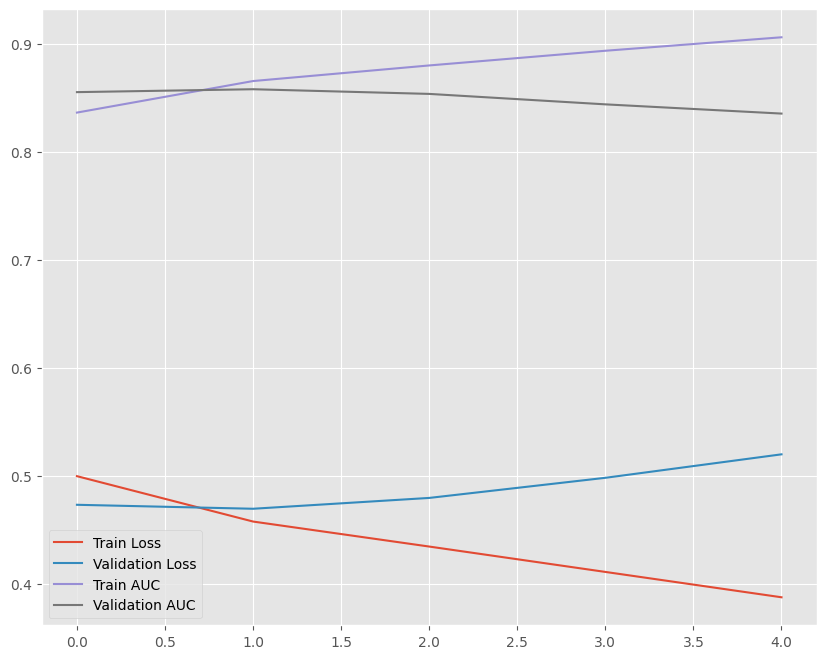

Validation AUC: 0.8353


In [15]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline1 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline1:.4f}")